In [39]:
import numpy as np
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
import random
from IPython.display import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\marti\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['linalg', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


This is a primer on Random Matrix Theory, <strong>(RMT)</strong> for short, and some interesting applications with a focus on tools from the scipy package and its linalg subset in particular.



Any good introduction to a mathematical topic includes some historical context. This is important because <strong>math without context obscures the intuition</strong> behind the original abstractions and leads one into a fog of confusion when solving problems. Random matrix theory was invented to describe the statistics of energy level spectra in nuclei. Often, the statistical behavior of systems with wave-like phenomena like interference and coherence can be quantitatively modeled by ensembles of matrices with random, uncorrelated entries.



A first object of study in Random Matrix Theory is an ensemble of matrices called the Gaussian orthogonal ensemble <strong>(GOE)</strong>. To produce an element of GOE is simple:
   * Generate an NxN matrix, $X$, with elements $x_i \sim  \mathcal{N}(\mu,\sigma) = \mathcal{N}(0,1)$.
   * Make it symmetric: $\displaystyle M = \frac{(X+X^T)}{2}$.


Eugene Wigner was a Hungarian Physicist famous for his work in atomic physics. <a href="https://en.wikipedia.org/wiki/Wigner_surmise"> Wigner's Surmise</a> was an important "guess" that the differences of eigenvalues, or spectral separation, divided by the mean of the differences would be universal as a distribution. 


$$\rho_{Wigner}(s) = (\pi s/2) \exp(-\pi s^2 / 4)$$

$S$ is the spacing and $D$ the mean distance between neighboring intervals, $\displaystyle s=\frac{S}{D}$, for a given atomic spectra.

Wigner's Surmise is exact for 2 by 2 matrices but does not hold for larger matrices. The Wigner Semicircle Law describes the limiting distribution of the spectrum of random symmetric matrices, but as a limiting distribution it describes the behavior of the eigenvalues as the size of the matrix approaches infinity. These limiting distributions come in several flavors for different matrices and are a fundamental concept in RMT.

In [55]:
#this code produces a GOE ensemble and collects a list of the eigenvalue separations.
def GOE(N):
    """
    Outputs an NxN Gaussian Orthogonal Ensemble
    """
    M = np.random.normal(size=(N,N))
    M = (M + M.T)
    return M

def GOE_Ensemble(num, N):
    """
    Outputs an ensemble of length num of NxN GOE matrices.
    
    """
    ensemble = [GOE(N) for n in range(num)]
    return ensemble
def EigDiffCentered(ensemble):
    """
    For each member of the ensemble, calculates the separation between center eigenvalues, and returns the
    differences as an array.
   
    """
   
    N = len(ensemble[0])
    diffs = []
    
    for mat in ensemble:
        eigenvalues = sort(eigvalsh(mat))
        diffs.append(eigenvalues[N//2] - eigenvalues[N//2-1])
 
    return diffs
def lambda_sampler(n_samples, N):
    lambdas = []
    ensemble = GOE_Ensemble(n_samples, N)
    for mat in ensemble:
        eigvals = eigvalsh(mat)
        lambdas.append(eigvals)
    return lambdas 

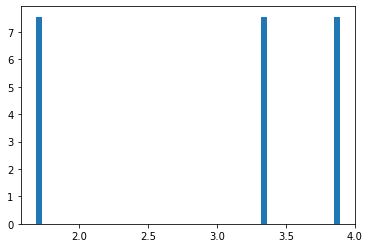

In [56]:
#Here we check our method and see three positive numbers that look like eigenvalue separation of symmetric 2x2 matrices
ensemble = GOE_Ensemble(3,2)
plt.hist(EigDiffCentered(ensemble), bins=50, density=True)
plt.show()

When we draw a larger sample, of size 10000, from the GOE we see that for larger matrices not only is the distribution now "smooth" but a pattern emerges. We have what appears to be a heavy-tailed distribution with a mean that is proportional to the size of the matrices.

In [57]:
X1 = EigDiffCentered(GOE_Ensemble(10000, 4))
X2 = EigDiffCentered(GOE_Ensemble(10000, 16))
X3 = EigDiffCentered(GOE_Ensemble(10000, 64))

<function matplotlib.pyplot.show(close=None, block=None)>

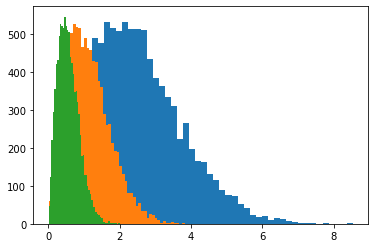

In [58]:
plt.hist(X1, bins=50)
plt.hist(X2, bins=50)
plt.hist(X3, bins=50)
plt.show

(array([[0., 0., 0., ..., 1., 1., 0.],
        [0., 0., 1., ..., 1., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        ...,
        [0., 1., 0., ..., 1., 1., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [0., 0., 2., ..., 1., 0., 0.]]),
 array([-12.95171882, -10.29930197,  -7.64688512,  -4.99446827,
         -2.34205142,   0.31036543,   2.96278228,   5.61519913,
          8.26761598,  10.92003282,  13.57244967]),
 <a list of 10000 BarContainer objects>)

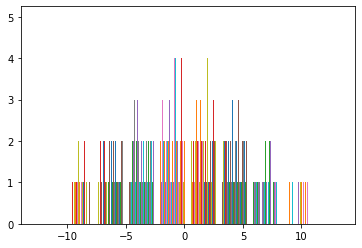

In [60]:
test = lambda_sampler(10000, 10)

plt.hist(test)


Similarly to symmetric matrices with elements drawn from a normal distribution, one might wonder about results for covariance matrices. The Marchenko-Pastur Law describes the limiting distribution or spectral density for just such matrices.

<a href="https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution">Spectral Distribution for eigenvalues of Covariance Matrices</a>

In [126]:
Image(url= "Randon Matrix Laws.jpg", width=1200, height=1200)

In [134]:
def randcv(n, p, s,
    t="N",
    f=None):
    """
    s number of covariance matrices of random matrices of n x p shape

    t: N for normal, B for binary distribution [0,1] 

    f: Filter. Z0 , Z1 for zscore on axis 0 or 1

    Returns  s x n x n array
    """
    r=[]
    for i in range(s):
        x=np.random.normal(size=(n,p))
        if t == "B":
            x=x>0.5
        if f == "Z0":
            x=scipy.stats.zscore(x, axis=0)
        elif f == "Z1":
            x=scipy.stats.zscore(x, axis=1)
        r.append(np.cov(x))
    return np.array(r)

def marchpast(l, g):
    "Marchenko-Pastur distribution"
    def m0(a):
        "Element wise maximum of (a,0)"
        return np.maximum(a, np.zeros_like(a))
    gplus=(1+g**0.5)**2
    gminus=(1-g**0.5)**2
    return np.sqrt(  m0(gplus  - l) *  m0(l- gminus)) / ( 2*np.pi*g*l)

def EE(a, gamma):
    "Calculate and show histogram of eigenvalues"
    ee, ev=np.linalg.eigh(a)
    nn, bb, patches=plt.hist(ee.ravel(), 
                                bins="auto", 
                                density=True)
    x=np.arange(bb[0], bb[-1], 0.003)
    plt.plot(x, marchpast(x, gamma))
    plt.ylim(top=nn[1:].max() * 1.1)
    plt.title('Empirical Distribution of Eigenvalues compared to Marchenko-Pastur Law')
    plt.show()

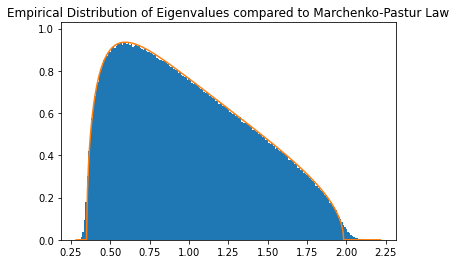

In [135]:
#This calculation will take a few seconds, be patient.
EE(randcv(50,300,50000, "N"), 5.0/30.)

In [129]:
def Wishart(n,p,baseVariance):
    returnVal=np.zeros([n,p])
    for rowIndex in range(0,n):
        nextRow= np.random.multivariate_normal(np.zeros(p),baseVariance*np.identity(p))
        returnVal[rowIndex,:]=nextRow
    return np.dot(np.transpose(returnVal),returnVal)
    
def InverseWishart(n,p,baseVariance):
    baseVariance=1/(baseVariance+.0)
    returnVal=Wishart(n,p,baseVariance)
    return np.linalg.linalg.inv(returnVal)